In [2]:
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('..')
from train.model import UNet3D
import os
from train.metrics import dice_score, iou_score, precision_score, recall_score
import numpy as np
import nibabel as nib
from tools.utils import show_mask

In [20]:
model = UNet3D()
#results1 = torch.load('../data/training_pipelines/train79_alpha0.5_gamma1.25/fold17/checkpoint_best.pth')
#results1 = torch.load('../data/pituitary/training_pipelines/train109_alpha0.5_gamma1.25/fold9/checkpoint_best.pth')
results1 = torch.load('../data/pituitary/training_pipelines/train120_alpha0.5_gamma1.25/fold8/checkpoint_best.pth')

In [21]:
#torch.save(results1['model_state_dict'],'../pitseg/checkpoint/pitseg_0.1.0.pt')
torch.save(results1['model_state_dict'],'../pitseg/checkpoint/pitseg_0.3.8.pt')

In [5]:
results1.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_loss', 'train_iou', 'train_dice', 'train_pre', 'train_recall', 'val_loss', 'val_iou', 'val_dice', 'val_pre', 'val_recall'])

In [6]:
len(results1['val_loss'])

27

(0.0, 1.1)

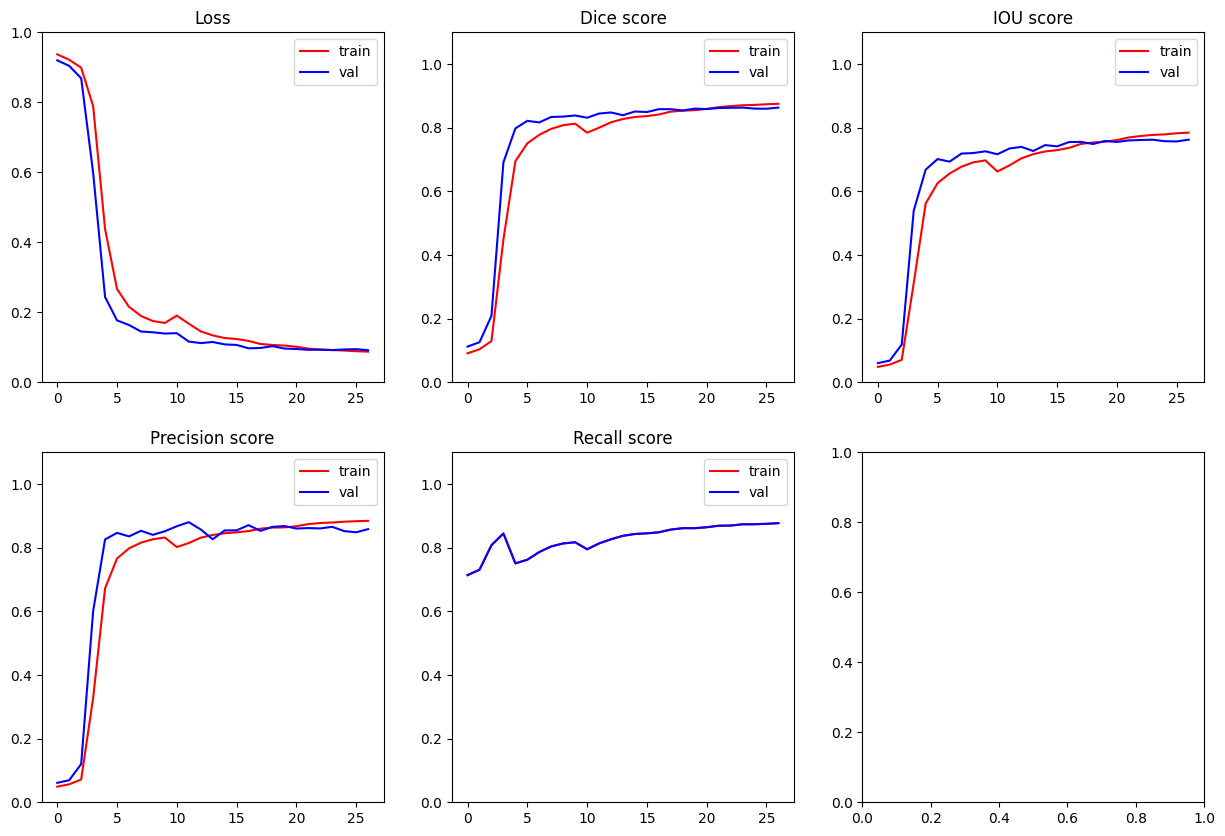

In [7]:
train_loss = results1['train_loss']
val_loss = results1['val_loss']
train_dice = results1['train_dice']
val_dice = results1['val_dice']
train_iou = results1['train_iou']
val_iou = results1['val_iou']
train_pre = results1['train_pre']
val_pre = results1['val_pre']
train_recall = results1['train_recall']
val_recall = results1['train_recall']
fig, ax = plt.subplots(2,3,figsize = (15,10))
ax[0,0].plot([i for i in range(len(train_loss))], train_loss, color = 'red', label = 'train')
ax[0,0].plot([i for i in range(len(val_loss))], val_loss, color = 'blue', label = 'val')
ax[0,0].legend()
ax[0,0].set_title('Loss')
ax[0,0].set_ylim([0,1])

ax[0,1].plot([i for i in range(len(train_dice))], train_dice, color = 'red', label = 'train')
ax[0,1].plot([i for i in range(len(val_dice))], val_dice, color = 'blue', label = 'val')
ax[0,1].legend()
ax[0,1].set_title('Dice score')
ax[0,1].set_ylim([0,1.1])

ax[0,2].plot([i for i in range(len(train_iou))], train_iou, color = 'red', label = 'train')
ax[0,2].plot([i for i in range(len(val_iou))], val_iou, color = 'blue', label = 'val')
ax[0,2].legend()
ax[0,2].set_title('IOU score')
ax[0,2].set_ylim([0,1.1])

ax[1,0].plot([i for i in range(len(train_pre))], train_pre, color = 'red', label = 'train')
ax[1,0].plot([i for i in range(len(val_pre))], val_pre, color = 'blue', label = 'val')
ax[1,0].legend()
ax[1,0].set_title('Precision score')
ax[1,0].set_ylim([0,1.1])

ax[1,1].plot([i for i in range(len(train_recall))], train_recall, color = 'red', label = 'train')
ax[1,1].plot([i for i in range(len(val_recall))], val_recall, color = 'blue', label = 'val')
ax[1,1].legend()
ax[1,1].set_title('Recall score')
ax[1,1].set_ylim([0,1.1])

In [9]:
model.load_state_dict(results1['model_state_dict'])
model.eval()
path = '../data/crop1'
output = '../data/prediction2'
files = [file for file in os.listdir(path)]
precisions = []
recalls =[]
ious = []
dices = []
imgs = []
labels = []
masks = []
for file in files:
    array = np.load(os.path.join(path,file))
    img = array['img'][0]
    imgs.append(img)
    img = torch.tensor(img).unsqueeze(0)
    label = array['label'][0]
    labels.append(label)
    label = torch.tensor(label).unsqueeze(0)
    logits = model(img.unsqueeze(1))
    logits = logits.squeeze(1)
    probs = torch.sigmoid(logits)
    pred = torch.where(probs > 0.6, 1, 0).int()
    ious.append(iou_score(label, pred).item())
    dices.append(dice_score(label, pred).item())
    precisions.append(precision_score(label, pred).item())
    recalls.append(recall_score(label, pred).item())

    masks.append(pred.numpy())
imgs = np.stack(imgs, axis = 0)
labels = np.stack(labels, axis = 0)
masks = np.concatenate(masks, axis = 0)
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)

In [10]:
print('IoU:',ious.mean())
print('Recall:',np.array(recalls).mean())
print('Precision:',np.array(precisions).mean())
print('Dice:',np.array(dices).mean())

IoU: 0.8132955675775354
Recall: 0.8646174696358767
Precision: 0.9337602501565759
Dice: 0.8962813361124559


In [7]:
files = np.array(files)
view_files = files[precisions < 0.8]
view_imgs = imgs[precisions < 0.8]
view_labels = labels[precisions < 0.8]
view_masks = masks[precisions < 0.8]

In [8]:
len(view_imgs)

2

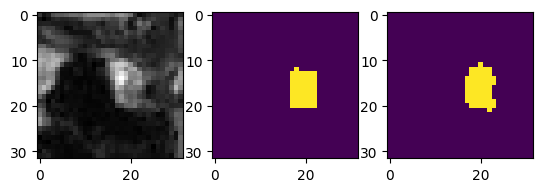

In [9]:
fig, ax = plt.subplots(1,3)
n = 0
s = 17
ax[0].imshow(view_imgs[n,s,:,:],'gray')
ax[1].imshow(view_labels[n,s,:,:])
ax[2].imshow(view_masks[n,s,:,:])

In [10]:
model.load_state_dict(results1['model_state_dict'])
path = '../data/test_data'
output = '../data/prediction2'
files = [file for file in os.listdir(path)]
precisions = []
recalls =[]
ious = []
dices = []
for file in files:
    array = np.load(os.path.join(path,file))
    img = array['img'][72:104,119:151, 53:85]
    #imgs.append(img)
    img = torch.tensor(img).unsqueeze(0)
    label = array['label'][72:104,119:151, 53:85]
    #labels.append(label)
    label = torch.tensor(label).unsqueeze(0)
    logits = model(img.unsqueeze(1))
    logits = logits.squeeze(1)
    probs = torch.sigmoid(logits)
    pred = torch.where(probs > 0.6, 1, 0).int()
    ious.append(iou_score(label, pred).item())
    dices.append(dice_score(label, pred).item())
    precisions.append(precision_score(label, pred).item())
    recalls.append(recall_score(label, pred).item())
    
    mask = np.zeros((176, 256, 176))
    mask[72:104,119:151, 53:85] = pred.numpy()
    affine = np.diag([1,1,1,1])
    nii_img = nib.Nifti1Image(mask.astype(np.uint8), affine)
    nib.save(nii_img, os.path.join(output, file.replace('npz','nii')))
#imgs = np.stack(imgs, axis = 0)
#labels = np.stack(labels, axis = 0)
#masks = np.concatenate(masks, axis = 0)
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)
print('IoU:',ious.mean())
print('Recall:',np.array(recalls).mean())
print('Precision:',np.array(precisions).mean())
print('Dice:',np.array(dices).mean())

IoU: 0.7180276393890381
Recall: 0.8488285064697265
Precision: 0.8372213542461395
Dice: 0.8351298332214355


# Validate across different folds

In [3]:
#path = '../data/training_pipelines/train79_alpha0.5_gamma1.25'
#path = '../data/pituitary/training_pipelines/train109_alpha0.5_gamma1.25'
path = '../data/pituitary/training_pipelines/train120_alpha0.5_gamma1.25'
training_path = '../data/pituitary/crop1'
test_path = '../data/pituitary/test_data'
train_files = [file for file in os.listdir(training_path)]
test_files = [file for file in os.listdir(test_path)]

precisions = []
recalls =[]
ious = []
dices = []
for fold in range(1,11):
    results = torch.load(os.path.join(path,f'fold{fold}','checkpoint_best.pth'))
    model = UNet3D()
    model.load_state_dict(results['model_state_dict'])
    model.eval()
    iou = 0
    prec = 0
    recall = 0
    dice = 0
    for file in train_files:
        array = np.load(os.path.join(training_path,file))
        img = array['img'][0]
        img = torch.tensor(img).unsqueeze(0)
        label = array['label'][0]
        label = torch.tensor(label).unsqueeze(0)
        logits = model(img.unsqueeze(1))
        logits = logits.squeeze(1)
        probs = torch.sigmoid(logits)
        pred = torch.where(probs > 0.5, 1, 0).int()
        iou += iou_score(label, pred).item()
        dice += dice_score(label, pred).item()
        prec += precision_score(label, pred).item()
        recall += recall_score(label, pred).item()
    ious.append(iou / len(train_files))
    dices.append(dice / len(train_files))
    precisions.append(prec / len(train_files))
    recalls.append(recall / len(train_files))
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)

In [4]:
print('IoU:',ious.mean())
print('Recall:',recalls.mean())
print('Precision:',precisions.mean())
print('Dice:',dices.mean())

IoU: 0.6832287730963251
Recall: 0.8483792381422631
Precision: 0.7560430214214328
Dice: 0.7680825881012016


In [5]:
print('IoU:',ious)
print('Recall:',recalls)
print('Precision:',precisions)
print('Dice:',dices)

IoU: [0.83509487 0.76069802 0.75590822 0.31719028 0.78964709 0.84878898
 0.84963011 0.85233586 0.05308524 0.76990907]
Recall: [0.93844385 0.92064828 0.8924705  0.42203384 0.90044518 0.9315729
 0.93137449 0.93783516 0.71810913 0.89085904]
Precision: [0.88491783 0.82039416 0.83745158 0.51997756 0.86940619 0.90625361
 0.9073094  0.90486764 0.05392658 0.85592565]
Dice: [0.90853476 0.8611816  0.85845366 0.450372   0.88078558 0.91715376
 0.91782774 0.91945398 0.09914512 0.86791766]


In [6]:
print('IoU:',ious.std())
print('Recall:',recalls.std())
print('Precision:',precisions.std())
print('Dice:',dices.std())

IoU: 0.25844676001921724
Recall: 0.15503107437307825
Precision: 0.25816521601953785
Dice: 0.25984738737231794


In [7]:
#path = '../data/training_pipelines/train79_alpha0.5_gamma1.5'
#training_path = '../data/crop1'
test_path = '../data/pituitary/test_data'
test_files = [file for file in os.listdir(test_path)]
precisions = []
recalls =[]
ious = []
dices = []
for fold in range(1,11):
    results = torch.load(os.path.join(path,f'fold{fold}','checkpoint_best.pth'))
    model = UNet3D()
    model.load_state_dict(results['model_state_dict'])
    model.eval()
    iou = 0
    prec = 0
    recall = 0
    dice = 0
    for file in test_files:
        array = np.load(os.path.join(test_path,file))
        img = array['img'][72:104,119:151, 53:85]
        img = torch.tensor(img).unsqueeze(0)
        label = array['label'][72:104,119:151, 53:85]
        label = torch.tensor(label).unsqueeze(0)
        logits = model(img.unsqueeze(1))
        logits = logits.squeeze(1)
        probs = torch.sigmoid(logits)
        pred = torch.where(probs > 0.5, 1, 0).int()
        iou += iou_score(label, pred).item()
        dice += dice_score(label, pred).item()
        prec += precision_score(label, pred).item()
        recall += recall_score(label, pred).item()
    ious.append(round(iou / 10,2))
    dices.append(round(dice / 10,2))
    precisions.append(round(prec / 10,2))
    recalls.append(round(recall / 10,2))
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)

In [8]:
print('IoU:',ious.mean())
print('Recall:',recalls.mean())
print('Precision:',precisions.mean())
print('Dice:',dices.mean())

IoU: 0.6119999999999999
Recall: 0.8539999999999999
Precision: 0.681
Dice: 0.722


In [9]:
precisions

array([0.79, 0.73, 0.76, 0.53, 0.78, 0.8 , 0.78, 0.79, 0.06, 0.79])

In [10]:
recalls

array([0.9 , 0.94, 0.91, 0.49, 0.91, 0.9 , 0.91, 0.91, 0.78, 0.89])

In [11]:
dices 

array([0.83, 0.81, 0.82, 0.48, 0.83, 0.84, 0.83, 0.84, 0.11, 0.83])

In [12]:
test_path = '../data/pituitary/kopf_NAKO/test'
test_files = [file for file in os.listdir(test_path)]
precisions = []
recalls =[]
ious = []
dices = []
w = 16
for fold in range(1,11):
    results = torch.load(os.path.join(path,f'fold{fold}','checkpoint_best.pth'))
    model = UNet3D()
    model.load_state_dict(results['model_state_dict'])
    model.eval()
    iou = 0
    prec = 0
    recall = 0
    dice = 0
    for file in test_files:
        array = np.load(os.path.join(test_path,file))
        img = array['img'][112-w:112+w,128-w:128+w,128-w:128+w]
        img = torch.tensor(img).unsqueeze(0)
        label = array['label'][112-w:112+w,128-w:128+w,128-w:128+w]
        label = torch.tensor(label).unsqueeze(0)
        logits = model(img.unsqueeze(1))
        logits = logits.squeeze(1)
        probs = torch.sigmoid(logits)
        pred = torch.where(probs > 0.5, 1, 0).int()
        iou += iou_score(label, pred).item()
        dice += dice_score(label, pred).item()
        prec += precision_score(label, pred).item()
        recall += recall_score(label, pred).item()
    ious.append(round(iou / len(test_files),2))
    dices.append(round(dice / len(test_files),2))
    precisions.append(round(prec / len(test_files),2))
    recalls.append(round(recall / len(test_files),2))
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)

In [13]:
print('IoU:',ious.mean())
print('Recall:',recalls.mean())
print('Precision:',precisions.mean())
print('Dice:',dices.mean())

IoU: 0.6620000000000001
Recall: 0.8560000000000001
Precision: 0.737
Dice: 0.756


In [14]:
print('IoU:',ious.std())
print('Recall:',recalls.std())
print('Precision:',precisions.std())
print('Dice:',dices.std())

IoU: 0.23865456207665503
Recall: 0.12642784503423288
Precision: 0.2449918365986916
Dice: 0.24703036250631216


In [15]:
precisions

array([0.83, 0.81, 0.82, 0.59, 0.85, 0.87, 0.87, 0.86, 0.04, 0.83])

In [16]:
recalls

array([0.92, 0.93, 0.92, 0.5 , 0.9 , 0.89, 0.9 , 0.91, 0.77, 0.92])

In [17]:
dices

array([0.86, 0.86, 0.86, 0.53, 0.87, 0.87, 0.88, 0.88, 0.08, 0.87])

## Check thyroid segmentation

In [2]:
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('..')
from train.model import UNet3D
import os
from train.metrics import dice_score, iou_score, precision_score, recall_score
import numpy as np
import nibabel as nib
from tools.utils import show_mask
from monai.transforms import (
    KeepLargestConnectedComponent,
    FillHoles,
    RemoveSmallObjects,
)
import scipy.ndimage as ndi

In [3]:
model = UNet3D(init_features = 32)
results1 = torch.load('../data/thyroids/training_pipelines/train9_alpha0.6_gamma1.5/fold8/checkpoint_best.pth')
model.load_state_dict(results1['model_state_dict'])
model.eval()
path = '../data/thyroids/training2/crop2'
files = [file for file in os.listdir(path)]
precisions = []
recalls =[]
ious = []
dices = []
imgs = []
labels = []
masks = []
for file in files:
    array = np.load(os.path.join(path,file))
    img = array['img'][0]
    imgs.append(img)
    img = torch.tensor(img).unsqueeze(0)
    label = array['label'][0]
    labels.append(label)
    label = torch.tensor(label).unsqueeze(0)
    logits = model(img.unsqueeze(1))
    logits = logits.squeeze(1)
    probs = torch.sigmoid(logits)
    pred = torch.where(probs > 0.5, 1, 0).int()
    clean = RemoveSmallObjects(min_size=100)(pred)#.numpy().squeeze(0)
    #struct = ndi.generate_binary_structure(3, 1)
    #post_pred = ndi.binary_dilation(clean, structure=struct, iterations = 1)
    #post_pred = torch.tensor(post_pred[np.newaxis, :, :], dtype = torch.int8)
    ious.append(iou_score(label, clean).item())
    dices.append(dice_score(label, clean).item())
    precisions.append(precision_score(label, clean).item())
    recalls.append(recall_score(label, clean).item())
    masks.append(clean.numpy())
imgs = np.stack(imgs, axis = 0)
labels = np.stack(labels, axis = 0)
masks = np.concatenate(masks, axis = 0)
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)
print('IoU:',ious.mean())
print('Recall:',recalls.mean())
print('Precision:',precisions.mean())
print('Dice:',dices.mean())

IoU: 0.7018386887555773
Recall: 0.911478878422217
Precision: 0.7565676823935725
Dice: 0.8230400793254375


Text(0.5, 1.0, 'Model prediction')

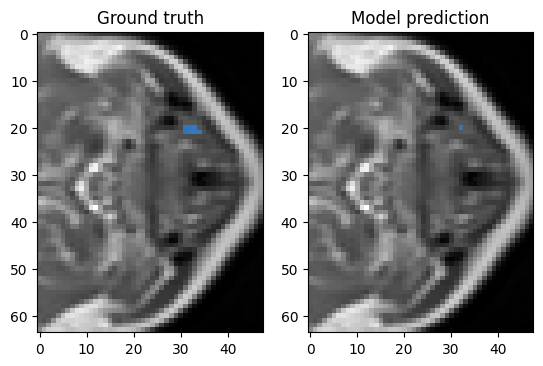

In [4]:
fig, ax = plt.subplots(1,2)
n = 2
s = 10
ax[0].imshow(imgs[n,:,:,s],'gray')
show_mask(labels[n,:,:,s], ax[0])
ax[0].set_title('Ground truth')

ax[1].imshow(imgs[n,:,:,s],'gray')
show_mask(masks[n,:,:,s], ax[1])
ax[1].set_title('Model prediction')

In [5]:
test_path = '../data/thyroids/training2/test_data'
#output = '../data/prediction'
precisions = []
recalls =[]
ious = []
dices = []
masks = []
test_files = [file for file in os.listdir(test_path)]
model = UNet3D(init_features=32)
model.load_state_dict(results1['model_state_dict'])
model.eval()
xw = 32
yw = 16
zw = 8
for file in test_files:
    array = np.load(os.path.join(test_path,file))
    img = array['img'][128-xw:128+xw,112-yw:112+yw,46-zw:46+zw]
    img = torch.tensor(img).unsqueeze(0)
    label = array['label'][128-xw:128+xw,112-yw:112+yw,46-zw:46+zw]
    label = torch.tensor(label).unsqueeze(0)
    logits = model(img.unsqueeze(1))
    logits = logits.squeeze(1)
    probs = torch.sigmoid(logits)
    pred = torch.where(probs > 0.5, 1, 0).int()
    clean = RemoveSmallObjects(min_size=100)(pred)#.numpy().squeeze(0)
    #struct = ndi.generate_binary_structure(3, 2)
    #post_pred = ndi.binary_opening(clean, structure=struct, iterations = 1)
    #post_pred = torch.tensor(post_pred[np.newaxis, :, :], dtype = torch.int8)
    ious.append(iou_score(label, clean).item())
    dices.append(dice_score(label, clean).item())
    precisions.append(precision_score(label, clean).item())
    recalls.append(recall_score(label, clean).item())
    masks.append(clean.numpy())
ious = np.array(ious)
precisions = np.array(precisions) 
recalls = np.array(recalls) 
dices = np.array(dices)

print('IoU:',ious.mean())
print('Recall:',recalls.mean())
print('Precision:',precisions.mean())
print('Dice:',dices.mean())

IoU: 0.6351290464401245
Recall: 0.7811347126960755
Precision: 0.787696921825409
Dice: 0.7756199598312378


In [6]:
results1 = torch.load('../data/thyroids/training_pipelines/train9_alpha0.6_gamma1.5/fold8/checkpoint_best.pth')
torch.save(results1['model_state_dict'], '../thyseg/checkpoint/thyseg112_0.1.0.pt')